# Header
Author: Wang Dong  
Email: wang0dong@gmail.com, dwang2014@my.fit.edu  
Date: 10/27/2023  

In [1]:
# Libraries 
import os
import imageio.v2 as imageio
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from mpl_toolkits import mplot3d
# plt.style.use('seaborn-poster')

In [2]:
# function definition
# Parses the json file
def json_read(filename):
    try:
        with open(os.path.abspath(filename)) as f:    
            data = json.load(f)
        return data
    except:
        raise ValueError("Unable to read JSON {}".format(filename))

# Define the path to the MP4 video file
def read_frame(video_path, frame_number_to_read):

    # Create a video reader object using imageio
    video_reader = imageio.get_reader(video_path)
    frame = video_reader.get_data(frame_number_to_read)
#     # Opencv uses BGR so we convert to RGB here 
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
    # Close the video reader
    video_reader.close()
    return frame

# retrieve Lambda and extrinsic matrix from calibration file
def projmatrix(calibration, view):
    # Get the calibration matrices
    Lambda = np.array(calibration[view]['K'])      # Intrinsic params.
    Omega  = np.array(calibration[view]['R'])      # Rotation
    tau    = np.array(calibration[view]['t'])      # Translation
    dist   = np.array(calibration[view]['dist'])   # Lens distortion
    intrinsic_matrix = np.append(Lambda, np.reshape([0,0,0],(3,1)), axis = 1)
    extrinsic_matrix = np.block([Omega, np.reshape(tau, (3,1))])
    extrinsic_matrix = np.append(extrinsic_matrix, [[0,0,0,1]], axis = 0)

#     np.set_printoptions(precision=3) 
#     print("----------------------------------------")
#     print("Calibration matrices of cambear {}".format(view))
#     print("----------------------------------------")
#     print("Lambda = \n",np.matrix(Lambda),"\n")
#     print("Intrinsic Matrix = \n",intrinsic_matrix,"\n")                                 
#     print("Omega = \n",np.matrix(Omega),"\n") 
#     print("tau = \n",np.matrix(tau),"\n")
#     print("dist = \n",np.matrix(dist),"\n")    
#     print("Extrinsic Matrix = \n", extrinsic_matrix)

    #     pmatrix = Lambda @ np.block([Omega, np.reshape(tau, (3,1))])
    return Lambda, extrinsic_matrix
    
# projecting
def projecting(pmatrix, points):
    points_transpose= points.transpose()
    pionts_tilde = np.block([[points_transpose],[np.ones([1,np.shape(points_transpose)[1]])]])
    x_tilde = pmatrix @ pionts_tilde

    # Convert coordinates from homogeneous to Cartesian
    x = np.zeros([2,np.shape(points_transpose)[1]])          # Create matrix to store image coords                          
    x[0][:] = x_tilde[0][:] / x_tilde[2][:]   # Vectorized division (avoid using loops!) 
    x[1][:] = x_tilde[1][:] / x_tilde[2][:]
    
    return x.transpose()

# # plotting
# def plotting(x, calibration, view, frameidx):
#     img = read_frame("{}.mp4".format(view), frameidx) 
#     Lambda = np.array(calibration[view]['K'])      # Intrinsic params.
#     dist   = np.array(calibration[view]['dist'])   # Lens distortion

#     img_corrected = cv2.undistort(img, Lambda, dist)
#     plt.figure(figsize=(10,6))
#     plt.imshow(img_corrected, aspect='auto')

#     for i in range(0, int(len(x)/2)):
#         xx = [x[i][0],x[i+4][0]]
#         yy = [x[i][1],x[i+4][1]]
#         plt.plot(xx,yy, 'ro-')
#     for i in range(0, int(len(x))):
#         if i == 3 or i == 7:
#             xx = [x[i][0],x[i-3][0]]
#             yy = [x[i][1],x[i-3][1]]
#         else:
#             xx = [x[i][0],x[i+1][0]]
#             yy = [x[i][1],x[i+1][1]]
#         plt.plot(xx,yy, 'ro-')
#     plt.savefig("example_%s.jpg" %(view) , dpi=200)
    

In [3]:
# manual pick 14 points in each image 
# Image features (corners) hardcoded
features = [] 
# view 3_2, frame 1
imageCorners = np.float32([[1211,512],[1081,432],[1271,415],[1420,477], # checkboard 
                          [1434,422],[1405,409],[1432,407],[1465,417], # chair legs
                          [1442,374],[1414,370],[1442,367],[1468,372], # chair seat
                          [1415,332],[1440,331]]) # chair ear
imageCorners = imageCorners.T;
features.append(imageCorners)
# view 6_3, frame 528
imageCorners = np.float32([[1227,424],[986,408],[1028,333],[1242,346], # checkboard 
                           [1130,290],[1086,286],[1094,273],[1138,275], # chair legs
                           [1131,246],[1092,246],[1097,234],[1136,233], # chair seat
                           [1088,212],[1093,201]]) # chair ear
imageCorners = imageCorners.T;
features.append(imageCorners)
# view 6_5, frame 1
imageCorners = np.float32([[516,386],[676,373],[743,420],[553,442], # checkboard 
                           [732,479],[780,473],[802,491],[755,499], # chair legs
                           [732,430],[777,428],[800,442],[754,445], # chair seat
                           [785,388],[805,400]]) # chair ear
imageCorners = imageCorners.T;
features.append(imageCorners)

In [4]:
# read inputs
view_list = ['3_2','6_3','6_5']
frameidx_list = [1,528,1]
imgs = []

# read videos and save the unobstructed images
# for idx in range(len(view_list)):
#     image = read_frame("{}.mp4".format(view_list[idx]), frameidx_list[idx])
#     imageio.imwrite("sample_image_{}.png".format(view_list[idx]), img)
#     imgs.append(image)   

# or read frames
for idx in range(len(view_list)):
    image_path = "sample_image_{}.png".format(view_list[idx])
    image = imageio.imread(image_path)
    imgs.append(image)
#     plt.imshow(image)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()

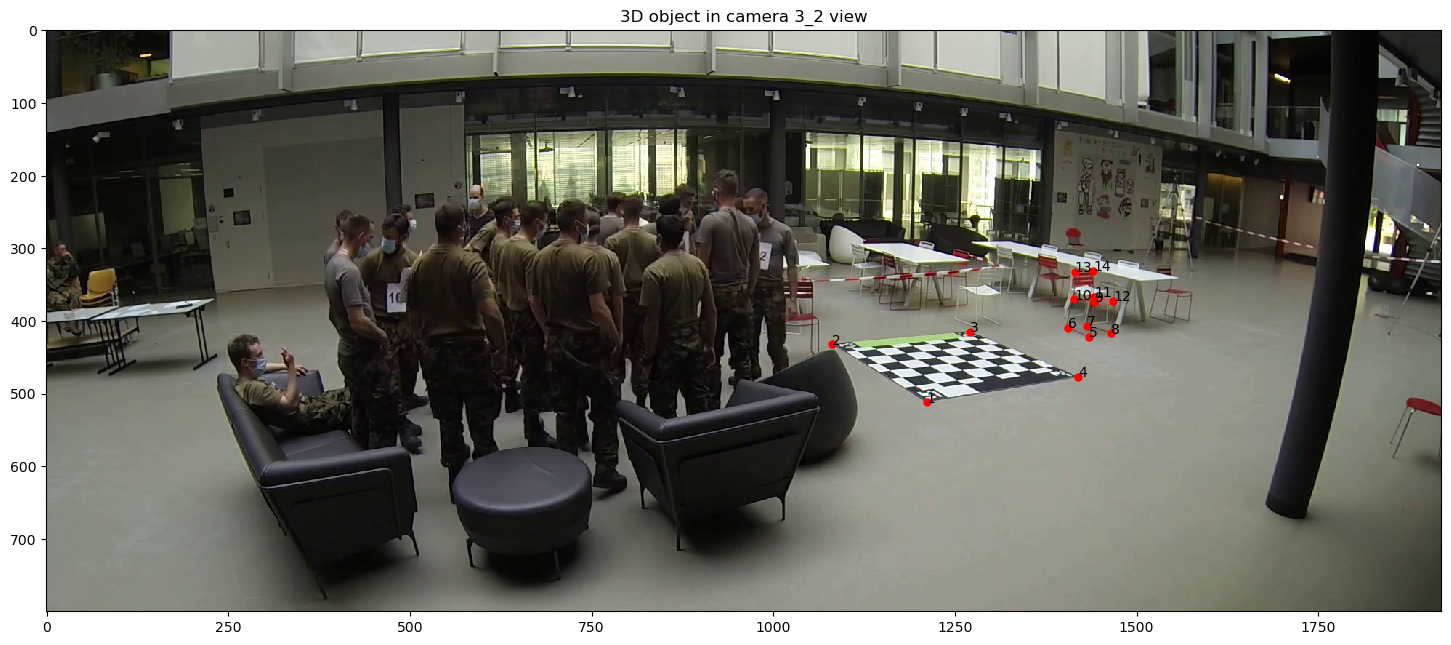

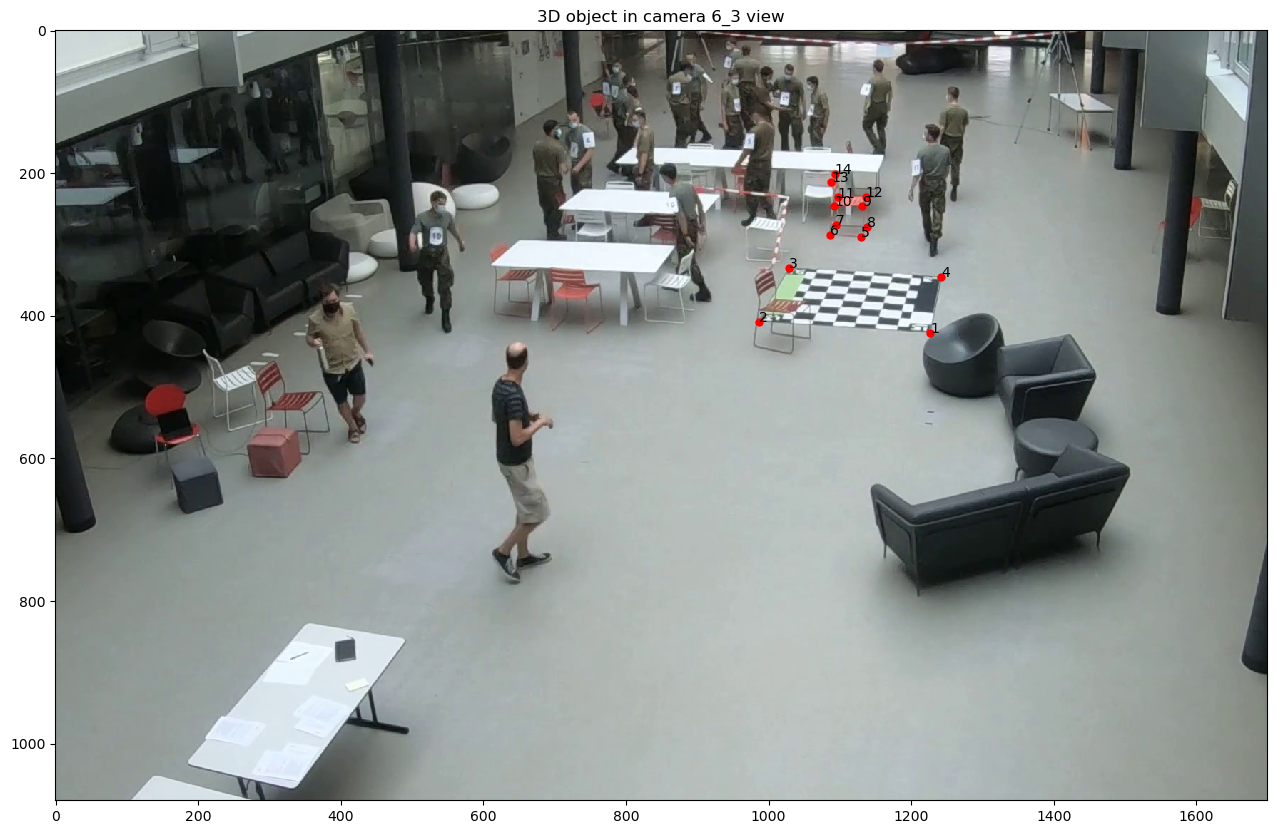

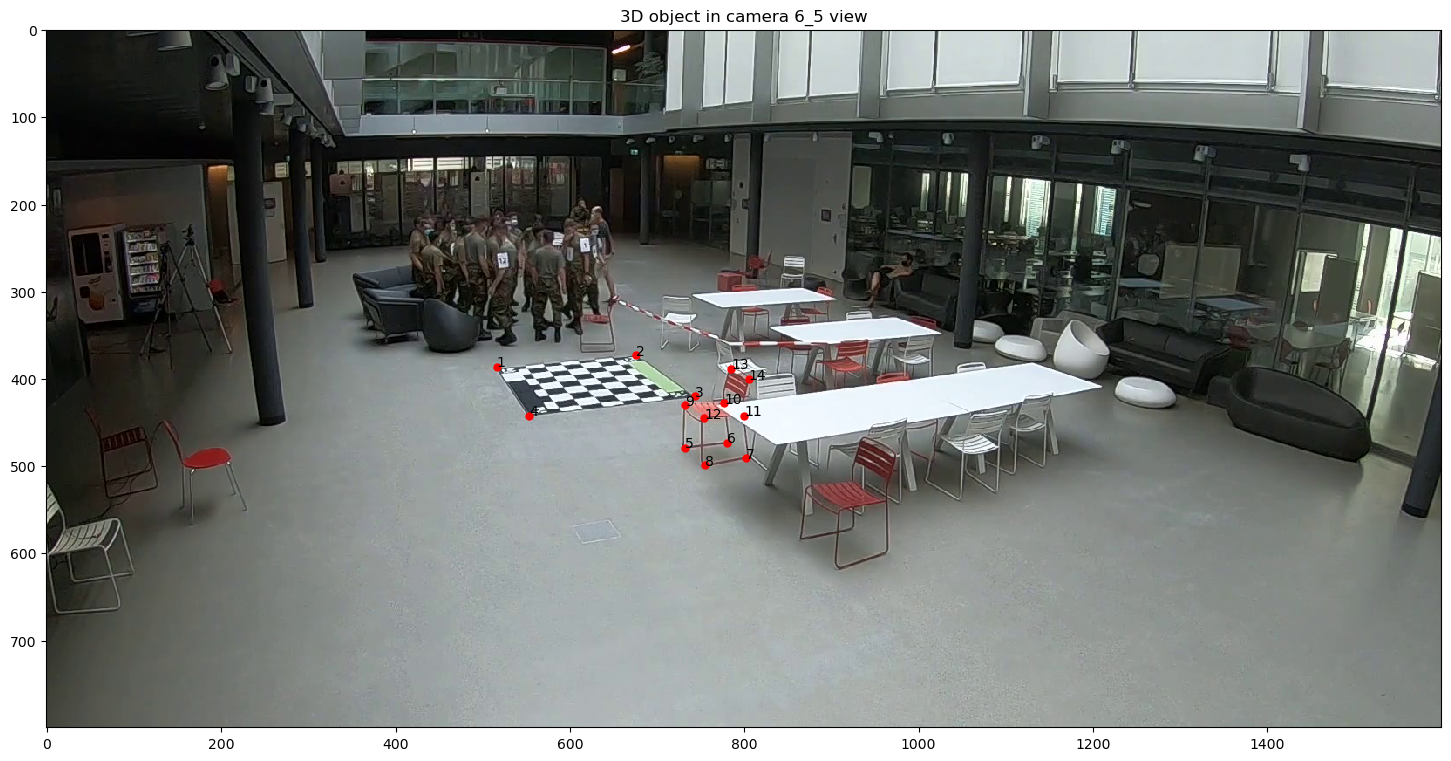

In [5]:
# switch disable or enable the Qt backend for pop-up window
%matplotlib inline
# %matplotlib qt

# hardcoded points visualization in three frames
for idx in range(len(imgs)):
    im = imgs[idx]
    imageCorners = features[idx]
   # Display corners on image
#     fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(18, 10))
    ax.imshow(im, interpolation='nearest')
    ax.plot(imageCorners[0,:], imageCorners[1,:], 'ro', markersize=5)
    plt.title('3D object in camera {} view'.format(view_list[idx]))
    for i in range(len(imageCorners[0,:])):
        plt.text(imageCorners[0,i], imageCorners[1,i], str(i + 1))


In [6]:
#  Define the optimization function
def dist_sum(x):
    # w
    w3D = x[:3]
    # x
    index = int(x[-1])
    # measured 2D value in image
    sample = feature2Ds_by_obj[index]
    
    dist_sum = 0
    
    # loop through each camera
    for idx in range(len(view_list)):
        view = view_list[idx]
        R = np.array(calibration[view]['R'])
        rvec = cv2.Rodrigues(R)[0]
        t = np.array(calibration[view]['t'])
        K = np.array(calibration[view]['K'])
        dist = np.array(calibration[view]['dist'])

        # projected 2D value
        w2D = cv2.projectPoints(w3D, rvec, t, K, dist)[0].reshape(-1,2)
        result = w2D.flatten()
#         print(result)
#         print(sample[idx])

        #  Calcuate the diff between 2D measure value and projected value in each camera view
        # formula (x_j - pinhole[w, Lambda, Omega, tau])^T (x_j - pinhole[w, Lambda, Omega, tau])
        # then sum all three camera results
        dist_sum += sum(i*i for i in (sample[idx]-result))
        
    return(dist_sum)

In [7]:
# Read json file containing the calibration data
calibration = json_read("calibration.json")

'''
Normalize the 2D object coordinates and reorder the axes
'''
# 3 camera view 14 object 2D pionts coordinates (x, y, 1) in  (3 cameras X 3 coordinates X 14 objects)
normalized_feature2Ds_by_camera = []
for idx in range(len(view_list)):
    view = view_list[idx]
    Lambda, extrinsic_matrix = projmatrix(calibration, view)
#     print(Lambda)
#     print(extrinsic_matrix)
    # standard 2D image coordinates
    feature2D = features[idx]
    feature2D = np.append(feature2D, [[1]*len(feature2D[0])], axis = 0)
#         np.set_printoptions(precision=3) 
    # normalized 2D image coordinates
    normalized_feature2D = np.linalg.inv(Lambda) @ feature2D
    normalized_feature2Ds_by_camera.append(normalized_feature2D)
# print(normalized_feature2Ds_by_camera)

# swap axes to (14 objects X 3 coordinates X 3 cameras) 
normalized_feature2Ds_by_obj = np.swapaxes(normalized_feature2Ds_by_camera, 0, 2)
# swap axes to (14 objects X 3 cameras X 3 coordinates) 
normalized_feature2Ds_by_obj = np.swapaxes(normalized_feature2Ds_by_obj, 1, 2)
# print(normalized_feature2Ds_by_obj)

# swap axes to (14 objects X 3 cameras X 2 2D coordinates) 
feature2Ds_by_obj = np.swapaxes(features, 0, 2)
feature2Ds_by_obj = np.swapaxes(feature2Ds_by_obj, 1, 2)
# print(feature2Ds_by_obj)

'''
Inferring 3D world position
'''
return_3D_obj = []
# loop each object point
for obj_id in range(len(normalized_feature2Ds_by_obj)):
    sample = normalized_feature2Ds_by_obj[obj_id]
    sample2D = feature2Ds_by_obj[obj_id]

    A_matrix = []
    b_matrix = []    

    # loop each camera
    for j in range(len(sample)):
        view = view_list[j]
        Lambda, extrinsic_matrix = projmatrix(calibration, view)
        obj = sample[j]
    #     print("intrinsic_matrix")
    #     print(intrinsic_matrix)
    #     print("extrinsic_matrix")
    #     print(extrinsic_matrix)
        a = extrinsic_matrix[2][0] * obj[0] - extrinsic_matrix[0][0] # w_31 * x_prime - w_11
        b = extrinsic_matrix[2][1] * obj[0] - extrinsic_matrix[0][1] # w_32 * x_prime - w_12
        c = extrinsic_matrix[2][3] * obj[0] - extrinsic_matrix[0][2] # w_33 * x_prime - w_13
        d = extrinsic_matrix[2][0] * obj[1] - extrinsic_matrix[1][0] # w_31 * y_prime - w_21
        e = extrinsic_matrix[2][1] * obj[1] - extrinsic_matrix[1][1] # w_32 * y_prime - w_22
        f = extrinsic_matrix[2][3] * obj[1] - extrinsic_matrix[1][2] # w_33 * y_prime - w_23
        g = extrinsic_matrix[0][3] -  extrinsic_matrix[2][3] * obj[0] # tau_x - tau_z * x_prime
        h = extrinsic_matrix[1][3] -  extrinsic_matrix[2][3] * obj[1] # tau_y - tau_z * y_prime
        # Stack linear constraints
        new_row1 = [a, b, c]
        new_row2 = [d, e, f]
        A_matrix.append(new_row1)        
        A_matrix.append(new_row2)        

        b_matrix.append([g])
        b_matrix.append([h])

    A_matrix = np.array(A_matrix)
    b_matrix = np.array(b_matrix)

    # LS solution for parameters 
    # Option 1 (A^T*A)^(-1)*A^T*b 
    w = np.linalg.inv(A_matrix.transpose() @ A_matrix) @ A_matrix.transpose() @ b_matrix
    # # Option 2 Use the pseudoinverse
    # pinv = np.linalg.pinv(A_matrix)
    # w = pinv.dot(b_matrix)
    # # Option 3 Use numpy.linalg.lstsq
    # w = np.linalg.lstsq(A_matrix, b_matrix, rcond=None)[0]
    # print(w.flatten())

    '''
    // Refine parameters with non-linear optimization
    '''
    # Initial guess (starting point for the optimization)
    initial_guess = np.append(w.flatten(), obj_id)
    # Define constraints - fixing the last variable (x[3])
    # last value is the index of feature2Ds_by_obj list, and it will be a fixed value in the optimization
    constraints = (
        {'type': 'eq', 'fun': lambda x: x[3] - obj_id}
    )

    # Perform the minimization
    result = minimize(dist_sum, initial_guess, constraints=constraints, method='SLSQP')
    # Extract the optimal solution
    optimal_solution = result.x
    w_hat= optimal_solution[:3]

    # return w
#     return_3D_obj.append(w.flatten().tolist())

    # return w_hat
    return_3D_obj.append(w_hat.tolist())


In [8]:
# 3D Plotting
%matplotlib qt

points = np.array(return_3D_obj)
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
x = points[:,0]
y = points[:,1]
z = points[:,2]

# scatter plot 3D points
ax.scatter(x, y, z)

# draw checkboard
# Define the points to connect with lines
x_line = [x[0], x[1]]  # X-coordinates of the two points
y_line = [y[0], y[1]]  # Y-coordinates of the two points
z_line = [z[0], z[1]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='b')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[1], x[2]]  # X-coordinates of the two points
y_line = [y[1], y[2]]  # Y-coordinates of the two points
z_line = [z[1], z[2]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='b')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[2], x[3]]  # X-coordinates of the two points
y_line = [y[2], y[3]]  # Y-coordinates of the two points
z_line = [z[2], z[3]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='b')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[3], x[0]]  # X-coordinates of the two points
y_line = [y[3], y[0]]  # Y-coordinates of the two points
z_line = [z[3], z[0]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='b')  # 'c' parameter specifies the line color

# draw chair
# Define the points to connect with lines
x_line = [x[4], x[8]]  # X-coordinates of the two points
y_line = [y[4], y[8]]  # Y-coordinates of the two points
z_line = [z[4], z[8]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[5], x[9]]  # X-coordinates of the two points
y_line = [y[5], y[9]]  # Y-coordinates of the two points
z_line = [z[5], z[9]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[6], x[10]]  # X-coordinates of the two points
y_line = [y[6], y[10]]  # Y-coordinates of the two points
z_line = [z[6], z[10]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[7], x[11]]  # X-coordinates of the two points
y_line = [y[7], y[11]]  # Y-coordinates of the two points
z_line = [z[7], z[11]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[8], x[9]]  # X-coordinates of the two points
y_line = [y[8], y[9]]  # Y-coordinates of the two points
z_line = [z[8], z[9]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[9], x[10]]  # X-coordinates of the two points
y_line = [y[9], y[10]]  # Y-coordinates of the two points
z_line = [z[9], z[10]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[10], x[11]]  # X-coordinates of the two points
y_line = [y[10], y[11]]  # Y-coordinates of the two points
z_line = [z[10], z[11]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[11], x[8]]  # X-coordinates of the two points
y_line = [y[11], y[8]]  # Y-coordinates of the two points
z_line = [z[11], z[8]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[9], x[12]]  # X-coordinates of the two points
y_line = [y[9], y[12]]  # Y-coordinates of the two points
z_line = [z[9], z[12]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[10], x[13]]  # X-coordinates of the two points
y_line = [y[10], y[13]]  # Y-coordinates of the two points
z_line = [z[10], z[13]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color
# Define the points to connect with lines
x_line = [x[12], x[13]]  # X-coordinates of the two points
y_line = [y[12], y[13]]  # Y-coordinates of the two points
z_line = [z[12], z[13]]  # Z-coordinates of the two points
# Create a line connecting the two points
ax.plot(x_line, y_line, z_line, c='r')  # 'c' parameter specifies the line color

# Define the range for each axis
ax.set_xlim(-0.5, 2.5)  # Define the range for the X-axis
ax.set_ylim(-2, 3.5)  # Define the range for the Y-axis
ax.set_zlim(0, 1)  # Define the range for the Z-axis

# Label data points
for idx in range(len(x)):
    ax.text(x[idx], y[idx], z[idx], '{}'.format(idx + 1), fontsize=12)

ax.set_title('3D Reconstruction')
# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

plt.show()